In [1]:
# import nibabel as nib
# import SimpleITK as sitk

# img_filename = "/projects/msieve/MedicalSieve/PatientData/KNIGHT/knight/data/case_00000"
# img = nib.load(img_filename+"/imaging.nii.gz")
# img2 = sitk.ReadImage(img_filename+"/imaging.nii.gz")


In [6]:
img.ImageSlicer()

TypeError: __init__() missing 1 required positional argument: 'img'

In [1]:

from fuse.data.datasets.dataset_default import DatasetDefault
from fuse.data.datasets.caching.samples_cacher import SamplesCacher
from fuse.data import PipelineDefault, OpSampleAndRepeat, OpToTensor, OpRepeat
from fuse.data.ops.op_base import OpBase
from fuse.data.ops.ops_aug_common import OpSample, OpRandApply
from fuse.data.ops.ops_common import OpLambda
from fuseimg.data.ops.aug.color import OpAugColor
from fuseimg.data.ops.aug.geometry import OpAugAffine2D
from fuseimg.data.ops.image_loader import OpLoadImage 
from fuseimg.data.ops.color import OpClip, OpToRange
import numpy as np
from fuse.data.utils.sample import get_sample_id
from typing import Hashable, List, Optional, Sequence, Tuple, Union
from functools import partial
from fuse.utils.ndict import NDict
import os
from fuse.utils.rand.param_sampler import Uniform, RandInt, RandBool
import torch
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from dataset import OpPrepare_Clinical, OpKnightSampleIDDecode
from fuseimg.data.ops.shape_ops import OpRandomCrop
%matplotlib inline


/projects/msieve_dev3/usr/il018850/tools/miniconda3/envs/fuse2_pub/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/projects/msieve/MedicalSieve/PatientData/KNIGHT/knight/data"
resize_to = (110,256,256)
static_pipeline = PipelineDefault("static", [
        # decoding sample ID
        (OpKnightSampleIDDecode(), dict()), # will save image and seg path to "data.input.img_path", "data.gt.seg_path" 
        
        # loading data
        (OpLoadImage(data_dir), dict(key_in="data.input.img_path", key_out="data.input.img", format="nib")),
        # (OpLoadImage(data_dir), dict(key_in="data.gt.seg_path", key_out="data.gt.seg", format="nib")),
        
        
        # fixed image normalization
        (OpClip(), dict(key="data.input.img", clip=(-62, 301))),
        (OpLambda(lambda x: (x - 104.0)/75.3 ), dict(key="data.input.img")), #kits normalization
        # (OpToRange(), dict(key="data.input.img", from_range=(-500, 500), to_range=(0, 1))),
        
        # transposing so the depth channel will be first
        (OpLambda(lambda x: np.moveaxis(x, -1, 0)), dict(key="data.input.img")), # convert image from shape [H, W, D] to shape [D, H, W] 
        (OpPrepare_Clinical(), dict()), #process clinical data

    ])

val_dynamic_pipeline = PipelineDefault("dynamic", [
            
    # resize image to (110, 256, 256)
    # (OpLambda(func=partial(my_resize, resize_to=(110, 256, 256))), dict(key="data.input.img")),

    # Numpy to tensor
    (OpToTensor(), dict(key="data.input.img")),
    (OpToTensor(), dict(key="data.input.clinical.all")),

    
    (OpRandomCrop(), dict(key="data.input.img", out_size=resize_to, centralize=True)),
    # (OpLambda(lambda x: aug_op_random_crop_and_pad(x, resize_to, centralize=False)), dict(key="data.input.img")),
    # add channel dimension -> [C=1, D, H, W]
    (OpLambda(lambda x: x.unsqueeze(dim=0)), dict(key="data.input.img")),  
]) 

train_dynamic_pipeline = PipelineDefault("dynamic", [
            
    # resize image to (110, 256, 256)
    # (OpLambda(func=partial(my_resize, resize_to=(110, 256, 256))), dict(key="data.input.img")),

    # Numpy to tensor
    (OpToTensor(), dict(key="data.input.img")),
    (OpToTensor(), dict(key="data.input.clinical.all")),

    # affine transformation per slice but with the same arguments
    # (OpRandApply(OpSample(OpAugAffine2D()), 1) , dict(
    #     key="data.input.img",
    #     rotate=Uniform(-180.0,180.0),
    #     scale=Uniform(0.8, 1.2),
    #     flip=(RandBool(0.5).sample(), RandBool(0.5)),
    #     translate=(RandInt(-15, 15).sample(), RandInt(-15, 15))
    # )),
    (OpRandomCrop(), dict(key="data.input.img", out_size=resize_to)),
    # (OpLambda(lambda x: aug_op_random_crop_and_pad(x, resize_to, centralize=False)), dict(key="data.input.img")),
    # add channel dimension -> [C=1, D, H, W]
    (OpLambda(lambda x: x.unsqueeze(dim=0)), dict(key="data.input.img")),  
])

In [3]:
num_samples = 10
sample_ids=[f"case_{id:05d}" for id in range(num_samples)]
my_dataset = DatasetDefault(sample_ids=sample_ids,
    static_pipeline=static_pipeline,
    dynamic_pipeline=train_dynamic_pipeline,
)
my_dataset.create()

In [9]:
a = my_dataset[7]

2.6162019 -2.2045152


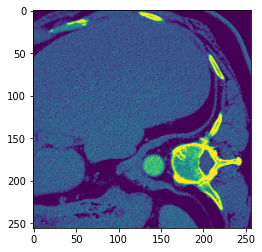

2.6162019 -2.2045152


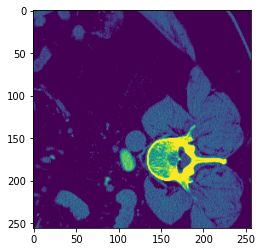

0.0 0.0


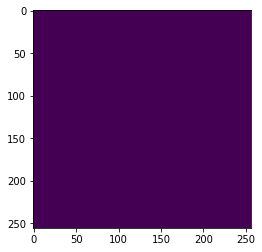

IndexError: index 400 is out of bounds for dimension 1 with size 110

In [10]:
for i in [10,55,100,400,600,750]:
    img = a["data.input.img"][0,i,:,:].numpy()
    print(img.max(), img.min())
    plt.imshow(img)
    plt.show()

In [7]:
a["data.input.img"].shape

torch.Size([1, 256, 256, 110])

In [6]:
a["data.input.img"][0,0,0,0].float().dtype

torch.float32

In [6]:
b = my_dataset[0]["data.input.clinical"]

(array([1.3422469e+08, 2.8640560e+06, 6.5688070e+06, 9.2477600e+06,
        2.7454010e+06, 9.6909200e+05, 7.6067800e+05, 5.3501600e+05,
        4.1236800e+05, 1.8421160e+06]),
 array([-2.20451527, -1.72244356, -1.24037185, -0.75830013, -0.27622842,
         0.20584329,  0.68791501,  1.16998672,  1.65205843,  2.13413015,
         2.61620186]),
 <BarContainer object of 10 artists>)

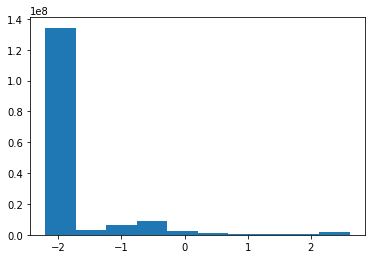

In [22]:
plt.hist(a.flatten())

In [36]:
a.shape

torch.Size([1, 256, 256, 110])

In [17]:
import pandas as pd
cols = ['case_id', 'age_at_nephrectomy', 'body_mass_index', 'gender', 'comorbidities', \
                                      'smoking_history', 'radiographic_size', 'last_preop_egfr', 'aua_risk_group']
        
json_data = pd.read_json("/projects/msieve/MedicalSieve/PatientData/KNIGHT/knight/data/knight.json")[cols]

In [34]:
sum = 0
for d in json_data["comorbidities"]:
    # print(d.values())
    sum += any(x for x in d.values())
sum

129

In [65]:
a = json_data[json_data["case_id"]=="case_00000"].to_dict("records")[0]
a.keys()

dict_keys(['case_id', 'age_at_nephrectomy', 'body_mass_index', 'gender', 'comorbidities', 'smoking_history', 'radiographic_size', 'last_preop_egfr'])

In [11]:
uniq = set()
for d in json_data["last_preop_egfr"]:
    uniq.add(d["value"])
uniq

{17.0,
 38.0,
 41.0,
 42.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 '>=90',
 None}